##### import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/full_ts_v")

In [4]:

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id[0]
    experiment_id = df.experiment_id[0]     

    #midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df["specie"] = df["ProteinName"].map(specie_mapper)
    df = df.set_index(["specie", "ProteinName", "FullPeptideName", "sample_id", "experiment_id"])
    df = df[["Intensity"]]
    df = pd.DataFrame(df.values, index = df.index)
    
    return df


In [5]:

dfs = []
for file in os.listdir():
    if file[-4:] == ".tsv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 0)
df = np.log2(df)


HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
33070 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
31895 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
32521 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
31588 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
33516 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
31707 significantly identified peptides at 0.01 FDR-treshold.



In [28]:
x = len(df[df.index.get_level_values("sample_id") == "1"].index.get_level_values("FullPeptideName").unique())
x_paper = 34851
print(f"Iteration 1 has {x} peptides identified.")
print(f"Reported iteration 1 is {x_paper} peptides identifies. ")
print(f"Diff {x_paper - x} ({(x_paper/x - 1)})")

Iteration 1 has 32214 peptides identified.
Reported iteration 1 is 34851 peptides identifies. 
Diff 2637 (0.0818588191469547)


In [29]:
x = len(df[df.index.get_level_values("sample_id") == "2"].index.get_level_values("FullPeptideName").unique())
x_paper = 35110
print(f"Iteration 2 has {x} peptides identified.")
print(f"Reported iteration 2 is {x_paper} peptides identifies. ")
print(f"Diff {x_paper - x} ({(x_paper/x - 1)})")

Iteration 2 has 33628 peptides identified.
Reported iteration 2 is 35110 peptides identifies. 
Diff 1482 (0.044070417509218585)


In [34]:

import matplotlib.pyplot as plt
import seaborn as sns 

def get_peptide_mu_sigma(df):
    df_means = df.groupby(df.index.get_level_values("FullPeptideName")).mean()
    
    df_stat = pd.DataFrame(df_means.values, index = df_means.index, columns = ["mu"])
    df_stat["std"] = df.groupby(df.index.get_level_values("FullPeptideName")).std()
    df_stat["std/mu-ratio"] = df_stat["std"] / df_stat["mu"]
    return df_stat

def select_specie_and_sample(df, specie = "HUMAN", sample = "1"):
    return df.iloc[(df.index.get_level_values("specie") == specie) & (df.index.get_level_values("sample_id") == sample), :]


Text(0.5, 1.0, 'std/mu ratio for log-transformed peptide values')

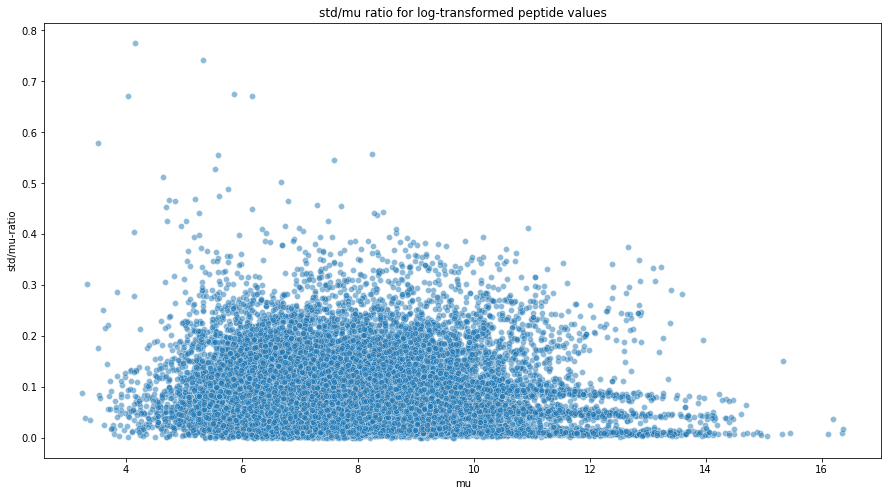

In [35]:

df_stat = get_peptide_mu_sigma(df)
f, ax = plt.subplots(1, 1, figsize = (15,8))
sns.scatterplot(ax = ax, data = df_stat, x = "mu", y = "std/mu-ratio", alpha = 0.5)
plt.title("std/mu ratio for log-transformed peptide values")



Text(0.5, 1.0, 'std/mu ratio for log-transformed peptide values')

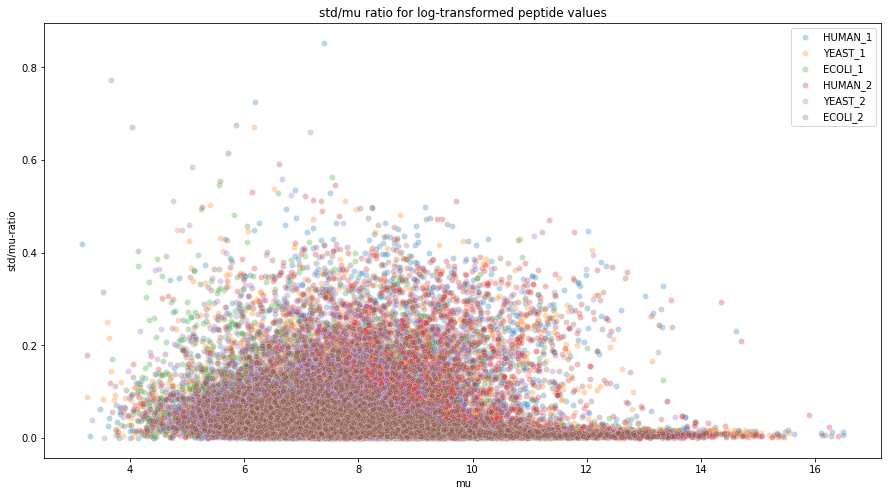

In [36]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "HUMAN", sample = "1")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "YEAS8", sample = "1")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "ECOLI", sample = "1")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "HUMAN", sample = "2")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "YEAS8", sample = "2")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "ECOLI", sample = "2")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
plt.legend(labels=['HUMAN_1', 'YEAST_1', "ECOLI_1", "HUMAN_2", "YEAST_2", "ECOLI_2"])
plt.title("std/mu ratio for log-transformed peptide values")


Using top 3 peptides most likely mean that alot of the less confident peptides get filtered away. However, triqler uses only the best scoring peptide, which also means that these peptides should be filtered away when using Triqler for protein quantification as well (I need to double check this).

The std seem to be more spread across low ranges. There does not seem to be a difference for sample of species.


In [37]:

df_counts = []
for specie in ["HUMAN", "YEAS8", "ECOLI"]:
    for sample in ["1", "2"]:
        df_tmp = select_specie_and_sample(df, specie = specie, sample = sample)
        df_tmp = df_tmp.groupby(df_tmp.index.get_level_values("FullPeptideName")).count() 
        df_tmp = pd.DataFrame(df_tmp.values, index = df_tmp.index, columns = ["count"])
        df_tmp["specie"] = specie
        df_tmp["sample"] = sample
        df_tmp["specie-sample"] = specie + "_" + sample
        df_counts.append(df_tmp)
df_count = pd.concat(df_counts, axis = 0).reset_index()



Text(0.5, 1.0, 'Peptide per protein counts.')

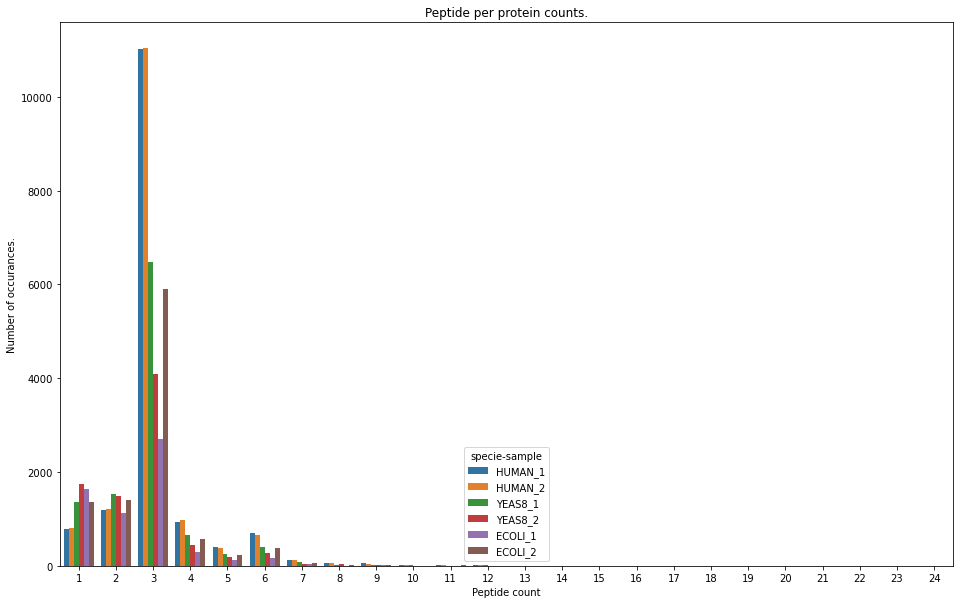

In [44]:
f, ax = plt.subplots(1, 1, figsize = (16,10))
ax = sns.countplot(x="count", hue="specie-sample", data=df_count)
plt.xlabel("Peptide count")
plt.ylabel("Number of occurances.")
plt.title("Peptide per protein counts.")

In [ ]:
#Make p-q plots, i.e. number of differentially expressed proteins for different q-value thresholds, at the min FC threshold as calculated by Triqler.


In [45]:

def read_in_and_filter_top3(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id[0]
    experiment_id = df.experiment_id[0]     
    def top3(df):
        df = (df.groupby('ProteinName')['Intensity'].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan)
                  .reset_index())
        #print(df.isna().sum())
        return df
    df_reduced = df[["ProteinName", "Intensity"]]
    df_protein = top3(df_reduced)
    df = df_protein
    df["specie"] = df.ProteinName.map(specie_mapper)
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df = df.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(df.values, columns = midx, index = df.index)
    
    return df

In [47]:

# highest scoring vs top highest intenstiy peptide?
# We take top3 intensity because we filter away so much with m_score < 0.01, all values should be good.

dfs = []
for file in os.listdir():
    if file[-4:] == ".tsv":
        dfs.append(read_in_and_filter_top3(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 1)

HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
33070 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
31895 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
32521 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
31588 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
33516 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
31707 significantly identified peptides at 0.01 FDR-treshold.



In [48]:
A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

In [49]:

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,1.01, 0.01):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,1.01, 0.01), columns = ["DE"])
    return res


In [56]:


import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()

True concentrations are:

HUMAN 1:1

YEAST 2:1

ECOLI 1:4

In [ ]:
#plot_pq(df_final, specie = "HUMAN")


In [ ]:
#plot_pq(df_final, specie = "ECOLI")


In [ ]:
#plot_pq(df_final, specie = "YEAS8")


In [60]:

import time
from triqler_output_to_df import  parse_triqler

os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq = df_triq[df_triq.q_value < q_val]
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAS8").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI"])
    return df


#start = time.time()
def get_DE_for_fcs():
    qs = []
    dfs = []
    for q in np.arange(0,1.01, 0.01):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = [round(i*0.2,2) for i in range(10)]
    res = []
    for fc in [round(i*0.2,2) for i in range(10)]:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,1.01, 0.01), columns = ["HUMAN", "YEAS8", "ECOLI"])
        res.append(df_res)
    return res

res = get_DE_for_fcs()

In [61]:

#Rewrite this to function subplot
def plot_pq_specie(specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    #specie = "ECOLI"
    
    for i in range(10):
        fc = fcs[i]
        res[i][specie].plot(ax = axs[row,col])
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].legend(labels=["Triqler", "OSW Top3"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()





NameError: name 'fcs' is not defined

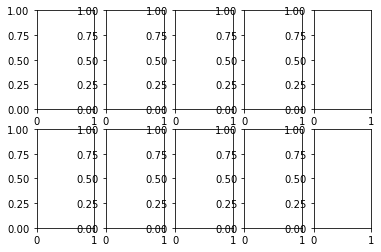

In [62]:
plot_pq_specie(specie = "HUMAN")

In [ ]:
plot_pq_specie(specie = "YEAS8")

In [ ]:
plot_pq_specie(specie = "ECOLI")